## まとめ
* 機械学習で使用するデータセットは、訓練データとテストデータに分けて使用する
* 訓練データで学習を行い、学習したモデルの汎化能力をテストデータで評価する
* ニューラルネットワークの学習は、損失関数を指標として、損失関数の値が小さくなるように、重みパラメータを更新する
* 重みパラメータを更新する際には、重みパラメータの勾配を利用して、勾配方向に重みの値を更新する作業を繰り返す
* 微小な値を与えたときの差分によって微分を求めることを数値微分という
* 数値微分によって、重みパラメータの勾配を求めることができる
* 数値微分による計算には時間がかかるが、その実装は簡単である。一方、次章で実装するやや複雑な誤差逆伝搬法は、高速に勾配を求めることができる。

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL/deep-learning-from-scratch/'
sys.path.append(ROOT_PATH)
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


## 損失関数

### 2乗和誤差
$$
E=\dfrac {1}{2} \sum_k(y_k-t_k)^2
$$

In [ ]:
#２乗和誤差の実装
def mean_squared_error(y,t):
  return 0.5*np.sum((y-t)**2)

In [ ]:
y=np.array([0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0])   #正解がラベル２
t=np.array([0,0,1,0,0,0,0,0,0,0])   #正解がラベル２

print(mean_squared_error(y,t))

0.09750000000000003


In [ ]:
y=np.array([0.1,0.05,0.05,0.0,0.05,0.1,0.0,0.7,0.0,0.0])   #正解がラベル7
t=np.array([0,0,1,0,0,0,0,0,0,0])   #正解がラベル２

print(mean_squared_error(y,t))

0.70875


### 交差エントロピー誤差
$$
E = -\sum_k t_k \log y_k
$$
* tはone-hot表現とし、正解のみ１、その他は０を示す
* そのため、交差エントロピー誤差は、tの正解ラベルに対する出力ｙだけが計算される（他は０になる）

In [ ]:
##交差エントロピー誤差の実装
def cross_entropy_error(y,t):
  delta=1e-7    #log0にならないように微小な値deltaを足しておく
  return -np.sum(t*np.log(y+delta))

In [ ]:
y=np.array([0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0])   #スコアの最大値がラベル２
t=np.array([0,0,1,0,0,0,0,0,0,0])   #正解がラベル２

print(cross_entropy_error(y,t))

0.510825457099338


In [ ]:
y=np.array([0.1,0.05,0.05,0.0,0.05,0.1,0.0,0.6,0.0,0.0])   #スコアの最大値がラベル7
t=np.array([0,0,1,0,0,0,0,0,0,0])   #正解がラベル２

print(cross_entropy_error(y,t))

2.9957302735559908


### ミニバッチ学習

In [ ]:
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=\
  load_mnist(normalize=True,one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [ ]:
#ミニバッチの実装
train_size=x_train.shape[0]
print(train_size)
batch_size=10
batch_mask=np.random.choice(train_size,batch_size)
print(batch_mask)
x_batch=x_train[batch_mask]
t_batch=t_train[batch_mask]
print(x_batch.shape)
print(x_batch.size)

60000
[42039 49291 30377 23744 26694 56622 26401 17609 18851 50926]
(10, 784)
7840


### 交差エントロピー誤差のバッチ対応

In [5]:
#正解ラベルがone-hot表現の場合の交差エントロピー誤差
def cross_entropy_error2(y,t):
  if y.ndim==1:
    t=t.reshape(1,t.size)   #y,tが行ベクトル（ndim=1）の場合は整形して1行＊（要素数）列の二次元配列（ndim=2)に変換する
    y=y.reshape(1,y.size)
    #print(y)    #[[要素,要素,...]]行列に変換
    #print(y.ndim)   #ndim=2

  print(y.shape)    #(1,要素数)
  batch_size=y.shape[0]
  return -np.sum(t*np.log(y+1e-7))/batch_size   #バッチの枚数で割って正規化する（バッチ１枚あたりの平均を求める）

In [6]:
y1=np.array([0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0])    #y,tが行ベクトル（ndim=1）の場合
t1=np.array([0,0,1,0,0,0,0,0,0,0])

y2=np.array([[[0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0],
            [0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]],
            [[0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0],
            [0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]]])   #ｙ，ｔがndim>=2の場合（データ2つのまとまり（バッチ）が２つの場合）
t2=np.array([[[0,0,1,0,0,0,0,0,0,0],
            [0,0,1,0,0,0,0,0,0,0]],
            [[0,0,1,0,0,0,0,0,0,0],
            [0,0,1,0,0,0,0,0,0,0]]]) 

print(cross_entropy_error2(y1,t1))
print(cross_entropy_error2(y2,t2))

(1, 10)
0.510825457099338
(2, 2, 10)
1.021650914198676


In [ ]:
#正解ラベルがone-hot表現ではない場合の交差エントロピー誤差計算
def cross_entropy_error3(y,t):
  if y.ndim==1:
    t=t.reshape(1,t.size)
    y=y.reshape(1,y.size)

  batch_size=y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size),t]+1e-7))/batch_size

In [ ]:
y2=np.array([0.1,0.05,0.05,0.0,0.05,0.1,0.0,0.6,0.0,0.0])
t2=np.array([7])

batch_size=y.shape[0]
print(cross_entropy_error3(y2,t2))

0.510825457099338


## 数値微分

### 微分
* 前方差分
$$
\dfrac {df(x)}{dx}=\lim_{h \rightarrow 0} \dfrac {f(x+h)-f(x)}{h}
$$

* 中心差分  
    中心差分を取ることで数値微分の誤差を減らすことができる  

$$
\dfrac {df(x)}{dx}=\lim_{h \rightarrow 0} \dfrac {f(x+h)-f(x-h)}{2h}
$$

In [ ]:
#数値微分の実装
def numerical_diff(f,x):
  h=1e-4    #丸め誤差を考慮すると1e-4くらいが精度が良い
  return (f(x+h)-f(x-h))/(2*h)    #中心差分を取ることで誤差をへらす

In [ ]:
#丸め誤差の確認
print(np.float16(10e-50))
print(np.float32(10e-50))
print(np.float64(10e-50))

0.0
0.0
1e-49


0.1999999999990898


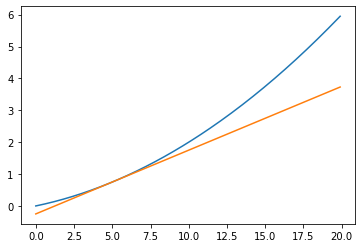

In [ ]:
def function_1(x):
  return 0.01*x**2+0.1*x

print(numerical_diff(function_1,5))
y0=-(numerical_diff(function_1,5)*5-function_1(5))  #y切片

x=np.arange(0,20,0.1)
plt.plot(x,function_1(x))   #関数function_1の表示
plt.plot(x,numerical_diff(function_1,5)*x+y0)   #接線の表示
plt.show()

### 偏微分

In [ ]:
#変数を固定した場合の偏微分の実装
def function_2(x):
  return np.sum(x**2)

def function_tmp1(x0):
  return x0**2.0+4.0**2.0

def function_tmp2(x1):
  return 3.0**2+x1**2.0

print(numerical_diff(function_tmp1,3))
print(numerical_diff(function_tmp2,4))

6.00000000000378
7.999999999999119


##勾配

In [ ]:
#偏微分の実装
def numerical_gradient(f,x):
  h=1e-4
  grad=np.zeros_like(x)

  for idx in range(x.size):
    tmp_val=x[idx]
    x[idx]=tmp_val+h
    fxh1=f(x)
    x[idx]=tmp_val-h
    fxh2=f(x)

    grad[idx]=(fxh1-fxh2)/(2*h)
    x[idx]=tmp_val

  return grad

In [ ]:
x=np.array([3.0,4.0])
numerical_gradient(function_2,x)

array([6., 8.])

### 勾配法

In [ ]:
#勾配法の実装
def gradient_descent(f,init_x,lr=0.01,step_num=100):
  x=init_x

  for i in range(step_num):
    grad=numerical_gradient(f,x)
    x-=lr*grad

  return x

In [ ]:
#勾配法で最小値を求める
init_x=np.array([-3.0,4.0])
print(gradient_descent(function_2,init_x,lr=0.1,step_num=100))
print(gradient_descent(function_2,init_x,lr=10,step_num=100))   #学習率が大きすぎる場合
print(gradient_descent(function_2,init_x,lr=1e-10,step_num=100))    #学習率が小さすぎる場合

[-6.11110793e-10  8.14814391e-10]
[ 2.34235971e+12 -3.96091057e+12]
[ 2.34235971e+12 -3.96091057e+12]


### ニューラルネットワークに対する勾配

In [ ]:
#簡単なニューラルネットワークの例
from common.functions import softmax,cross_entropy_error
from common.gradient import numerical_gradient
import numpy as np

class simpleNet:
  def __init__(self):
    self.W=np.random.randn(2,3)

  def predict(self,x):
    return np.dot(x,self.W)

  def loss(self,x,t):
    z=self.predict(x)
    y=softmax(z)
    loss=cross_entropy_error(y,t)

    return loss

net=simpleNet()
print('W=',net.W)
x=np.array([0.6,0.9])
p=net.predict(x)
print('p=',p)
print('np.argmax(p)=',np.argmax(p))
t=np.array([0,0,1])   #正解ラベル
loss=net.loss(x,t)
print('loss=',loss)

f=lambda w:net.loss(x,t)

dW=numerical_gradient(f,net.W)
print('dW=',dW)

W= [[-0.68726177  0.79576543  0.46422363]
 [ 0.44178116  0.31231718 -0.28734873]]
p= [-0.01475402  0.75854472  0.01992033]
np.argmax(p)= 1
loss= 1.4009298818857359
dW= [[ 0.1427828   0.30939642 -0.45217922]
 [ 0.2141742   0.46409462 -0.67826883]]


## 学習アルゴリズムの実装

### 2層ニューラルネットワークのクラス

In [8]:
from common.functions import *
from common.gradient import numerical_gradient

#2層ニューラルネットワーク
class TwoLayerNet:
  def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
    #重みの初期化
    self.params={}
    self.params['W1']=weight_init_std*np.random.randn(input_size,hidden_size)
    self.params['b1']=np.zeros(hidden_size)
    self.params['W2']=weight_init_std*np.random.randn(hidden_size,output_size)
    self.params['b2']=np.zeros(output_size)

  def predict(self,x):
    W1,W2=self.params['W1'],self.params['W2']
    b1,b2=self.params['b1'],self.params['b2']

    a1=np.dot(x,W1)+b1
    z1=sigmoid(a1)
    a2=np.dot(z1,W2)+b2
    y=softmax(a2)

    return y

  def loss(self,x,t):
    y=self.predict(x)
    return cross_entropy_error(y,t)

  def accuracy(self,x,t):
    y=self.predict(x)
    y=np.argmax(y,axis=1)
    t=np.argmax(t,axis=1)
    return np.sum(y==t)/float(x.shape[0])   #x.shape[0](バッチサイズ)で割ってバッチサイズごとの平均を出す

  def numerical_gradient(self,x,t):
      loss_W=lambda W:self.loss(x,t)    #損失関数の定義
      grads={}
      grads['W1']=numerical_gradient(loss_W,self.params['W1'])
      grads['b1']=numerical_gradient(loss_W,self.params['b1'])
      grads['W2']=numerical_gradient(loss_W,self.params['W2'])
      grads['b2']=numerical_gradient(loss_W,self.params['b2'])

      return grads

### ミニバッチ学習の実装

In [9]:
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=\
  load_mnist(normalize=True,one_hot_label=True)

train_loss_list=[]

#ハイパーパラメータ
iters_num=10000
train_size=x_train.shape[0]
batch_size=100
learning_rate=0.1
train_acc_list=[]
test_acc_list=[]
#1エポックあたりの繰り返し数
iter_per_epoch=max(train_size/batch_size,1)

network=TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

for i in range(iters_num):
  #ミニバッチの取得
  batch_mask=np.random.choice(train_size,batch_size)
  x_batch=x_train[batch_mask]
  t_batch=t_train[batch_mask]

  #勾配の計算
  grad=network.numerical_gradient(x_batch,t_batch)

  #パラメータの更新
  for key in ('W1','b1','W2','b2'):
    network.params[key]-=learning_rate*grad[key]

  #学習経過の記録
  loss=network.loss(x_batch,t_batch)
  train_loss_list.append(loss)

  #1エポックごとに認識精度を計算
  if i % iter_per_epoch==0:
    train_acc=network.accuracy(x_train,t_train)
    test_acc=network.accuracy(x_test,t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print('train acc, test acc | '+str(train_acc)+','+str(test_acc))

train acc, test acc | 0.10441666666666667,0.1028


KeyboardInterrupt: ignored